# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: number of training examples
n_train = len(train['sizes'])

# TODO: number of testing examples
n_test = len(test['sizes'])

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
n_classes = max(max(y_train), max(y_test)) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

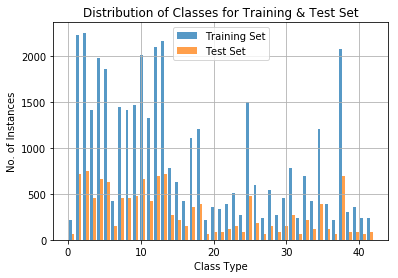

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
import matplotlib.pyplot as plt

plt.hist((y_train, y_test), 43, alpha = 0.75)

plt.xlabel('Class Type')
plt.ylabel('No. of Instances')
plt.grid(True)
plt.title('Distribution of Classes for Training & Test Set')
plt.legend(['Training Set', 'Test Set'], loc = 9)
plt.show()

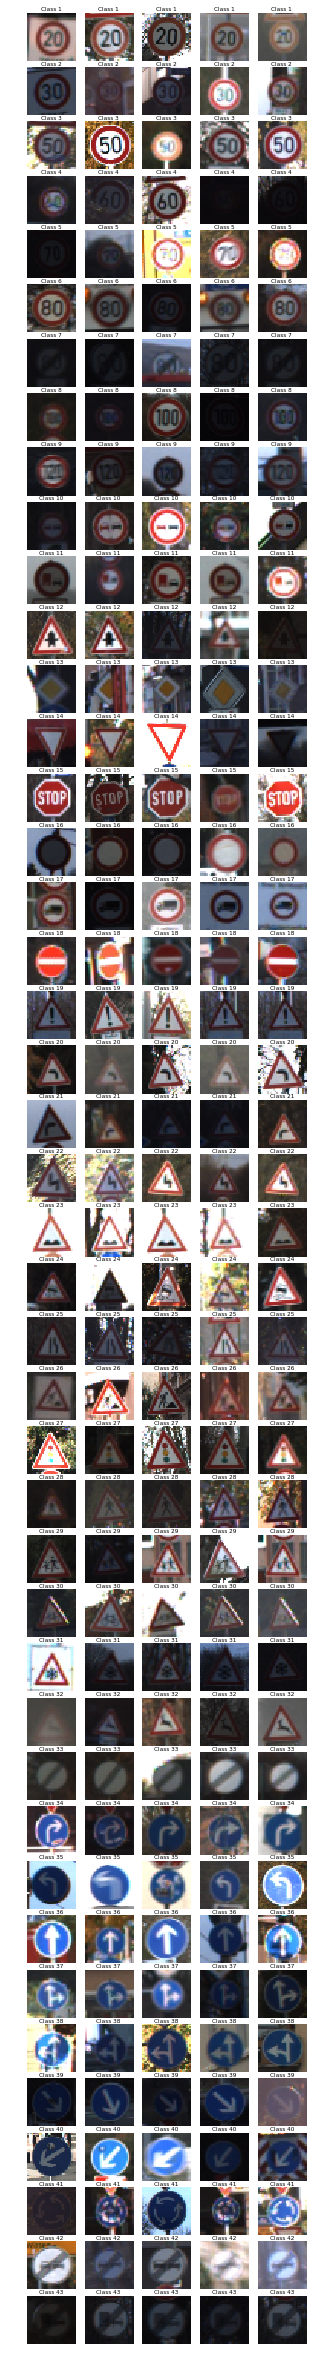

In [4]:
import matplotlib.gridspec as gridspec
import random

no_images = 5 
n_classes = 43
count = 0 
sample_size = 5
fig = plt.figure(figsize=(no_images, n_classes))
grid = gridspec.GridSpec(n_classes, no_images, wspace=0.2, hspace=0.0)

for i in range(n_classes):
    index = y_train == i
    sign  = X_train[index,] 
    for j in range(no_images):
        img = random.choice(sign) 
        ax = plt.Subplot(fig, grid[count])
        ax.axis('off')
        ax.imshow(img)
        ax.set_title('Class %s'% (i+1), fontsize='xx-small', verticalalignment = 'top')
        fig.add_subplot(ax)
        count +=1

plt.show()

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import matplotlib.image as mpimg
from collections import Counter
import copy

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

# Adding new images to balance the data set

z = Counter(y_train)
v =max(list(z.values()))
print("Original Distribution of Images :")
print()
print(z)
print()
X_train_temp = copy.deepcopy(X_train)
y_train_temp = copy.deepcopy(y_train)
print("Generating new images ...")

for i in range(n_classes):
    new = 0
    while (v - z[i] - new) > 1750 :
        index = y_train == i
        sign  = X_train[index,] 
        image = random.choice(sign) 
        for j in range(50):
            img = transform_image(image,10,10,5,brightness=1)
            new = new + 1
            X_train_temp = np.append(X_train_temp, [img], axis = 0)
            y_train_temp = np.append(y_train_temp, [i], axis = 0)
            
    print('Generating New Images for label ', i)

print("New Distribution of Images :")
print()
print(X_train_temp.shape)
print(y_train_temp.shape)
print(Counter(y_train_temp))

Original Distribution of Images :

Counter({2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 4: 1980, 5: 1860, 25: 1500, 9: 1470, 7: 1440, 3: 1410, 8: 1410, 11: 1320, 18: 1200, 35: 1200, 17: 1110, 14: 780, 31: 780, 33: 689, 15: 630, 26: 600, 28: 540, 23: 510, 30: 450, 6: 420, 16: 420, 34: 420, 22: 390, 36: 390, 20: 360, 40: 360, 21: 330, 39: 300, 24: 270, 29: 270, 27: 240, 32: 240, 41: 240, 42: 240, 0: 210, 19: 210, 37: 210})

Generating new images ...
Generating New Images for label  0
Generating New Images for label  1
Generating New Images for label  2
Generating New Images for label  3
Generating New Images for label  4
Generating New Images for label  5
Generating New Images for label  6
Generating New Images for label  7
Generating New Images for label  8
Generating New Images for label  9
Generating New Images for label  10
Generating New Images for label  11
Generating New Images for label  12
Generating New Images for label  13
Generating New Images for label  14
Gene

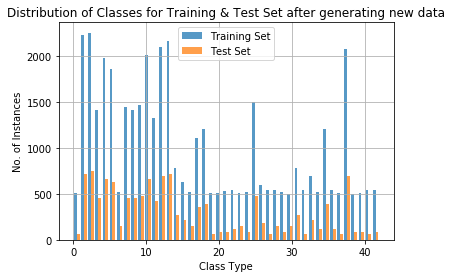

In [6]:
plt.hist((y_train_temp, y_test), 43, alpha = 0.75)

plt.xlabel('Class Type')
plt.ylabel('No. of Instances')
plt.grid(True)
plt.title('Distribution of Classes for Training & Test Set after generating new data')
plt.legend(['Training Set', 'Test Set'], loc = 9)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [7]:
X_train = copy.deepcopy(X_train_temp)
y_train = copy.deepcopy(y_train_temp)

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split

X_train = X_train/255.
X_train, y_train = shuffle(X_train, y_train)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [9]:
def LeNet(x, keep_prob):   
   
    mu = 0
    sigma = 0.1
        
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.0001
EPOCHS = 30
BATCH_SIZE = 16

logits = LeNet(x, keep_prob)
prediction = tf.nn.softmax(logits)
cross_entropy = -tf.reduce_sum(one_hot_y * tf.log(prediction + 1e-6), reduction_indices=1)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [11]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        if (i%10) == 0 :
            rate = rate*10
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    print()

Training...

EPOCH 1 ...
Validation Accuracy = 0.518

EPOCH 2 ...
Validation Accuracy = 0.676

EPOCH 3 ...
Validation Accuracy = 0.747

EPOCH 4 ...
Validation Accuracy = 0.801

EPOCH 5 ...
Validation Accuracy = 0.821

EPOCH 6 ...
Validation Accuracy = 0.844

EPOCH 7 ...
Validation Accuracy = 0.858

EPOCH 8 ...
Validation Accuracy = 0.877

EPOCH 9 ...
Validation Accuracy = 0.884

EPOCH 10 ...
Validation Accuracy = 0.903

EPOCH 11 ...
Validation Accuracy = 0.911

EPOCH 12 ...
Validation Accuracy = 0.912

EPOCH 13 ...
Validation Accuracy = 0.922

EPOCH 14 ...
Validation Accuracy = 0.920

EPOCH 15 ...
Validation Accuracy = 0.925

EPOCH 16 ...
Validation Accuracy = 0.931

EPOCH 17 ...
Validation Accuracy = 0.932

EPOCH 18 ...
Validation Accuracy = 0.933

EPOCH 19 ...
Validation Accuracy = 0.941

EPOCH 20 ...
Validation Accuracy = 0.942

EPOCH 21 ...
Validation Accuracy = 0.944

EPOCH 22 ...
Validation Accuracy = 0.943

EPOCH 23 ...
Validation Accuracy = 0.946

EPOCH 24 ...
Validation Accura

In [13]:
print("Testing Model..")
print()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Testing Model..

Test Accuracy = 0.886


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Every image was normalized so that the each pizel value ranged from -0.5 to 0.5 to help the optamizer descend easily
to a minimum value.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
 A plot was generated to see the distribution of images for each label. No. of images for each label 
was balanced by adding jittered images (using Vivek Yadav's code).It basically tilts, shears, moves and increases brightness of the images at random to generate new images. Then the images were shuffled and 20% 
of the training set was taken as validation set. Every image was normailized so that the image values 
varied from 0.0 to 1.0 .

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
 LeNet neural network was modfied for traffic classification. Additional dropout layers were added to prevent 
overfitting. 

 INPUT -> Convolution -> Relu Activation -> Dropout (50%) -> Max Pool -> Convolution -> Relu Activation -> 
 Dropout (50%) -> Max Pool -> Flatten -> Fully Connected -> Relu Activation  -> Fully Connected -> Relu Activation
 -> Fully Connected -> Logits
 
The architecture in detail:
 
Layer 1: Convolutional Layer. Input = 32x32x3. Output = 28x28x6 with a 5x5 filter and stride of 1 in both directions.
            RELU Activation. 
            Dropout. (with 50% dropout rate)
            Max Pooling. Input = 28x28x6. Output = 14x14x6.

Layer 2: Convolutional Layer. Input = 14x14x6. Output = 10x10x16 with a 5x5 filter and stride of 1 in both directions.
            RELU Activation.
            Dropout. (with 50% dropout rate)
            Max Pooling. Input = 10x10x16. Output = 5x5x16.

Flatten the input from previous layer Input = 5x5x16. Output = 400.

Layer 3: Fully Connected. Input = 400. Output = 120.
            RELU Activation.


Layer 4: Fully Connected. Input = 120. Output = 84.
            RELU Activation.

Layer 5: Fully Connected. Input = 84. Output = 43.
 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
For training the model Adam optimizer was used. Batch size was keot small at 16. A total of 40 epochs was used for 
training. Initial learning rate was fixed at 0.0001 and was gradually increased with every epoch. The reasons
for choosing the parameters are explained below.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
LeNet architerture was chosen as an inspiration since the task at hand was very similar to the one LeNet was originally used for. Choosing a higher learning rate increases the validation accuracy pretty quickly, but whne the learning late was lower, the validation accuracy over the period of time increased. So I decided to start with a low learning rate (indicating uncertainty in the beginning) and was gradually increased after every 10 epochs so that the optimizer quickly finds a good optimal solution. 
It was observed that lowering the batch size increased the overall accuracy of the network. Hence the batch size was kept low at 32.
Initially the Epoch size used was 10%. However, that resulted in a very low accuracy. So the Epoch size was gradually increased. Increasing the Epoch size increased the accuracy. However, no notable immprovement was observed after 40 Epochs, hence the Epoch size was fixed at 40.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
Seven images were randomly chosen from internet for classification. Some of the images are low quality which may make the classification slightly difficult.

Importing Images..



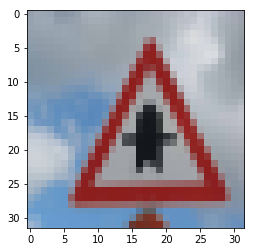

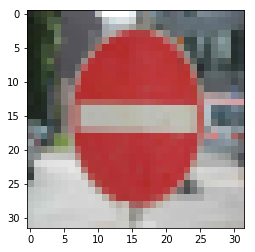

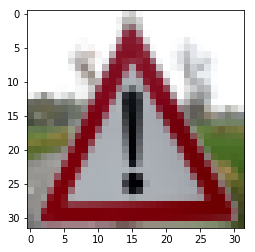

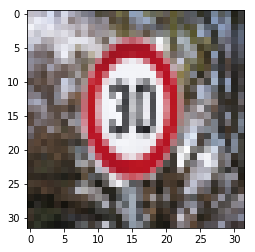

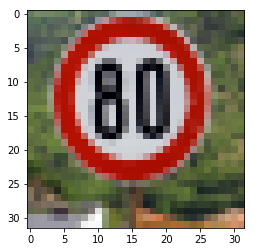

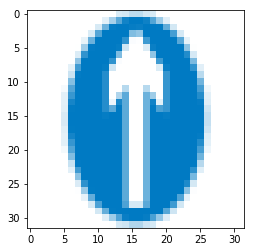

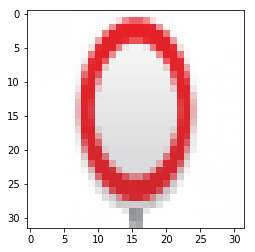

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

image = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg'
            , 'image7.jpg']
img   = []

print("Importing Images..")
print()

for i in image:
    image = mpimg.imread('test_images/' + i)
    image = cv2.resize(image,(32, 32), interpolation = cv2.INTER_AREA)
    img.append(image)
    plt.imshow(image)
    plt.show()

img = np.array(img)

In [22]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    classification = sess.run(prediction, {x: img, keep_prob: 1.0})
    top_five = sess.run(tf.nn.top_k(classification, 5), feed_dict={x: img, keep_prob: 1.0})

print(classification)
print()

for j in range(classification.shape[0]):
    print('Top Five predictions : ', top_five[1][j])
    print('Best prediction : ', (np.argmax(classification[j])))
    print()

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model performed reasonably well on the external images as well. It was able to correctly predict 5 out of 7 images (approx 71.4 %) with reasonably good confidence. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Actual class id for the images are 11, 17, 18, 01, 05, 35, 15. The best prediction for each image was 11, 17, 18, 0, 0, 35, 15. Clearly the network correctly predicted 5 out of 7 images. The network seemed pretty confident of its prediction as the probability of other next best prediction was nearly zero.

In [23]:
print(top_five)

TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[11,  0,  1,  2,  3],
       [17,  0,  1,  2,  3],
       [18,  0,  1,  2,  3],
       [ 0,  1,  2,  3,  4],
       [ 0,  1,  2,  3,  4],
       [35,  0,  1,  2,  3],
       [15,  0,  1,  2,  3]], dtype=int32))


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.